In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import urllib
from scipy.stats import mannwhitneyu
import re
import os.path
from langdetect import detect
import string
import nltk
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import fastcluster
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances
from scipy.spatial.distance import squareform
import sys
from scipy.cluster.hierarchy import fcluster, dendrogram
from nltk.stem.porter import PorterStemmer
import warnings
warnings.filterwarnings('ignore')
sys.setrecursionlimit(100000)
matplotlib.style.use('ggplot')

## YouTube - Exploratory Analyses
### Loading the dataset
First, let us load the dataset from the database.

In [2]:
con = sqlite3.connect('youtube.db')
video = pd.read_sql_query('''SELECT v.autoId as autoId, 
                                    v.id as id,
                                    v.categoryId as categoryId,
                                    v.channelId as channelId,
                                    v.publishedAt as publishedAt,
                                    v.title as title,
                                    v.description as description,
                                    v.viewCount as viewCount,
                                    v.likeCount as likeCount,
                                    v.dislikeCount as dislikeCount,
                                    v.favoriteCount as favoriteCount,
                                    v.commentCount as commentCount,
                                    v.duration as duration,
                                    v.defaultLanguage as defaultLanguage,
                                    c.title as channelTitle,
                                    c.description as channelDescription,
                                    c.publishedAt as channelPublishedAt,
                                    c.viewCount as channelViewCount,
                                    c.commentCount as channelCommentCount,
                                    c.subscriberCount as channelSubscriberCount,
                                    c.videoCount as channelVideoCount,
                                    c.country as channelCountry
                                    from video v left join channel c on v.channelId = c.id limit 10000''', con)

Next, let's examine the count of videos we collected. The tables are ``video``, ``url``, ``urlResolve``, and ``category``.

In [3]:
print video.shape

(10000, 22)


In [4]:
list(video.columns.values)

['autoId',
 'id',
 'categoryId',
 'channelId',
 'publishedAt',
 'title',
 'description',
 'viewCount',
 'likeCount',
 'dislikeCount',
 'favoriteCount',
 'commentCount',
 'duration',
 'defaultLanguage',
 'channelTitle',
 'channelDescription',
 'channelPublishedAt',
 'channelViewCount',
 'channelCommentCount',
 'channelSubscriberCount',
 'channelVideoCount',
 'channelCountry']

In [5]:
print video.shape

(10000, 22)


### Examining the affiliate video descriptions

What languages are these descriptions in?

In [6]:
print "hello"
def get_language(x):
    language = 'Unknown'
    try:
        language = detect(x.description.strip())
    except:
        pass
    return language

vids = video.apply(get_language, axis=1)
print vids.value_counts()
print "hello"

hello
en         3428
Unknown    2899
es          516
pt          363
ru          325
de          262
ja          222
fr          194
ko          189
ar          164
it          147
id          108
tr           95
vi           79
ca           77
th           75
ro           74
nl           73
pl           62
so           55
tl           54
no           42
sv           39
bg           33
hr           32
af           32
et           31
hu           30
da           27
fi           26
sw           25
cy           23
uk           21
el           20
he           17
sl           17
lt           17
zh-tw        17
cs           15
sq           14
sk           12
fa           12
zh-cn         9
mk            8
lv            5
bn            5
ur            3
hi            3
pa            1
mr            1
ta            1
te            1
dtype: int64
hello


In [7]:
videos_en = video[vids == 'en'].copy()

In [8]:
videos_en.shape

(3428, 22)

In [9]:
def isnumeric(character):
    return ord('0') <= ord(character) and ord(character) <= ord('9')

def get_search_regex(possible_code_bases):
    if possible_code_bases == None:
        return "(" + username + ").*[0-9]*"
    search_str = "("
    for base in possible_code_bases:
        search_str += base + "|"
    search_str = search_str[0:-1] + ").*[0-9]*"
    return search_str

def get_codes_from_username(username):
    usernames = []
    if username == None or username == "":
        return usernames
    usernames.append(re.escape(username))
                
    last_index_used = 0
    split_tokens = []
    initials = username[0]
    totalstring = username
    for i in range(len(username)-1):
        c = username[i]
        nc = username[i+1]
        if c == " ":
            if i == 0:
                continue
            split_tokens.append(username[last_index_used: i])
            usernames.append(re.escape(username[last_index_used: i]))
            usernames.append(re.escape(username[i+1:]))
            initials += username[i+1]
            last_index_used = i+1
        elif c.islower() and (nc.isupper() or isnumeric(nc)):
            split_tokens.append(username[last_index_used: i+1])
            usernames.append(re.escape(username[last_index_used: i+1]))
            usernames.append(re.escape(username[i+1:]))
            initials += username[i+1]
            last_index_used = i+1
        elif c.isupper() and isnumeric(nc):
            split_tokens.append(username[last_index_used: i+1])
            usernames.append(re.escape(username[last_index_used: i+1]))
            usernames.append(re.escape(username[i+1:]))
            initials += username[i+1]
            last_index_used = i+1
        elif isnumeric(c) and  not isnumeric(nc):
            split_tokens.append(username[last_index_used: i+1])
            usernames.append(re.escape(username[last_index_used: i+1]))
            usernames.append(re.escape(username[i+1:]))
            initials += username[i+1]
            last_index_used = i+1
    if last_index_used > 0:
        split_tokens.append(re.escape(username[last_index_used:]))
        totalstring = ""
        for item in split_tokens:
            totalstring += item
    
    usernames.append(re.escape(totalstring))
            
    for item in usernames:
        if len(item) < 3 and len(username) >= 3:
            usernames.remove(item)
    usernames.append(re.escape(initials))
    return usernames

applicable_vids = []
count = 0
for index, vid in videos_en.iterrows():
    possible_code_bases = get_codes_from_username(vid.channelTitle)
    #there is not a username
    if len(possible_code_bases) == 0 or (len(possible_code_bases) == 1 and possible_code_bases[0] == ""):
        continue
        
    search_regex_str = get_search_regex(possible_code_bases)
    coupon_regex = re.compile(search_regex_str)
    keyword_regex = re.compile("( code )|( coupon )|( promotion )| ( promo )")
    
    tokenize_regex = re.compile("(\r\n)|(\n)|(\.)|(\!)|(\?)")
    tokens = re.split(tokenize_regex, vid.description)
    for token in tokens:
        if token != None and re.search(coupon_regex, token) and re.search(keyword_regex, token):
            count += 1
            applicable_vids.append([vid.id, possible_code_bases, token])

print len(applicable_vids)

8


In [10]:
stemmer = PorterStemmer()

def tokenize(line):
    if (line is None):
        line = ''
    printable = set(string.printable)
    line = ''.join(filter(lambda x: x in printable, line)) 
    stopwords = nltk.corpus.stopwords.words('english')

    tokenizer = nltk.RegexpTokenizer(r'[a-zA-Z]*\'[a-zA-Z]*|\w+')
    
    tokens = []
    
    line = re.sub(r'(http[s]?://|www.)(?:[a-zA-Z]|[0-9]|[$-_@.&+]*|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))*', '', line).lower()
    tokens.extend(tokenizer.tokenize(line))
    
    tokens_ = [f.strip(string.punctuation) for f in tokens]
    tokens_ = [f for f in tokens_ if f != '' and f not in stopwords and len(f) != 1]
    tokens_ = [f for f in tokens_ if not (f.isdigit() or f[0] == '-' and f[1:].isdigit())]
    tokens_ = [stemmer.stem(f) for f in tokens_]

    return tokens_


In [11]:
# Add a sentence number value here
rows = []

def description_parse(desc):
    sentences = []
    for line in desc.splitlines():
        for sent in sent_tokenize(line):
            sentences.append(sent)
    
    return sentences

sentences = []
for index, row in videos_en.iterrows():
    sentences = description_parse(row.description)
    for sent in sentences:
        if len(tokenize(sent)) != 0:
            rows.append([row['id'], row['channelTitle'], row['description'], sent])

videos_en_new = pd.DataFrame(rows, columns=['id', 'channelTitle', 'description', 'sentence'])
print videos_en_new

                id         channelTitle  \
0      JnJCH-sPG3w        Vampire Tears   
1      JnJCH-sPG3w        Vampire Tears   
2      JnJCH-sPG3w        Vampire Tears   
3      o0fGfITO9-s           Pusalover™   
4      29XZ-QBPt-8      SantaMariaTimes   
5      29XZ-QBPt-8      SantaMariaTimes   
6      29xZ-_T_vKY         britkneelove   
7      29xZ-_T_vKY         britkneelove   
8      29xz-mBTWMs              Yokenvo   
9      0KTFf-4R4uY          Gloria Cook   
10     0KTFf-4R4uY          Gloria Cook   
11     0KTFf-4R4uY          Gloria Cook   
12     0KTFf-4R4uY          Gloria Cook   
13     0KTFf-4R4uY          Gloria Cook   
14     0KTFf-4R4uY          Gloria Cook   
15     0KTFf-4R4uY          Gloria Cook   
16     0KTFf-4R4uY          Gloria Cook   
17     0KTFf-4R4uY          Gloria Cook   
18     0KTFf-4R4uY          Gloria Cook   
19     0KTFf-4R4uY          Gloria Cook   
20     3cv_gT3w_7w             CBC News   
21     3cv_gT3w_7w             CBC News   
22     3cv_

In [12]:
countVec = CountVectorizer(tokenizer=tokenize, binary=True).fit(videos_en_new['sentence'])
print len(countVec.vocabulary_)

17203


In [13]:
lineVec = countVec.transform(videos_en_new['sentence'])
print 'done'

done


In [14]:
tfidfTrans = TfidfTransformer().fit(lineVec)
tfIdfMatrix = tfidfTrans.transform(lineVec)
print 'done'

done


In [15]:
tfIdfMatrix.shape

(19352, 17203)

In [16]:
dist = cosine_distances(lineVec)
print 'done'

done


In [17]:
distVec = squareform(dist, checks = False)
print 'done'

done


In [18]:
res = fastcluster.linkage(distVec, method = 'ward', preserve_input = False)
'done'

'done'

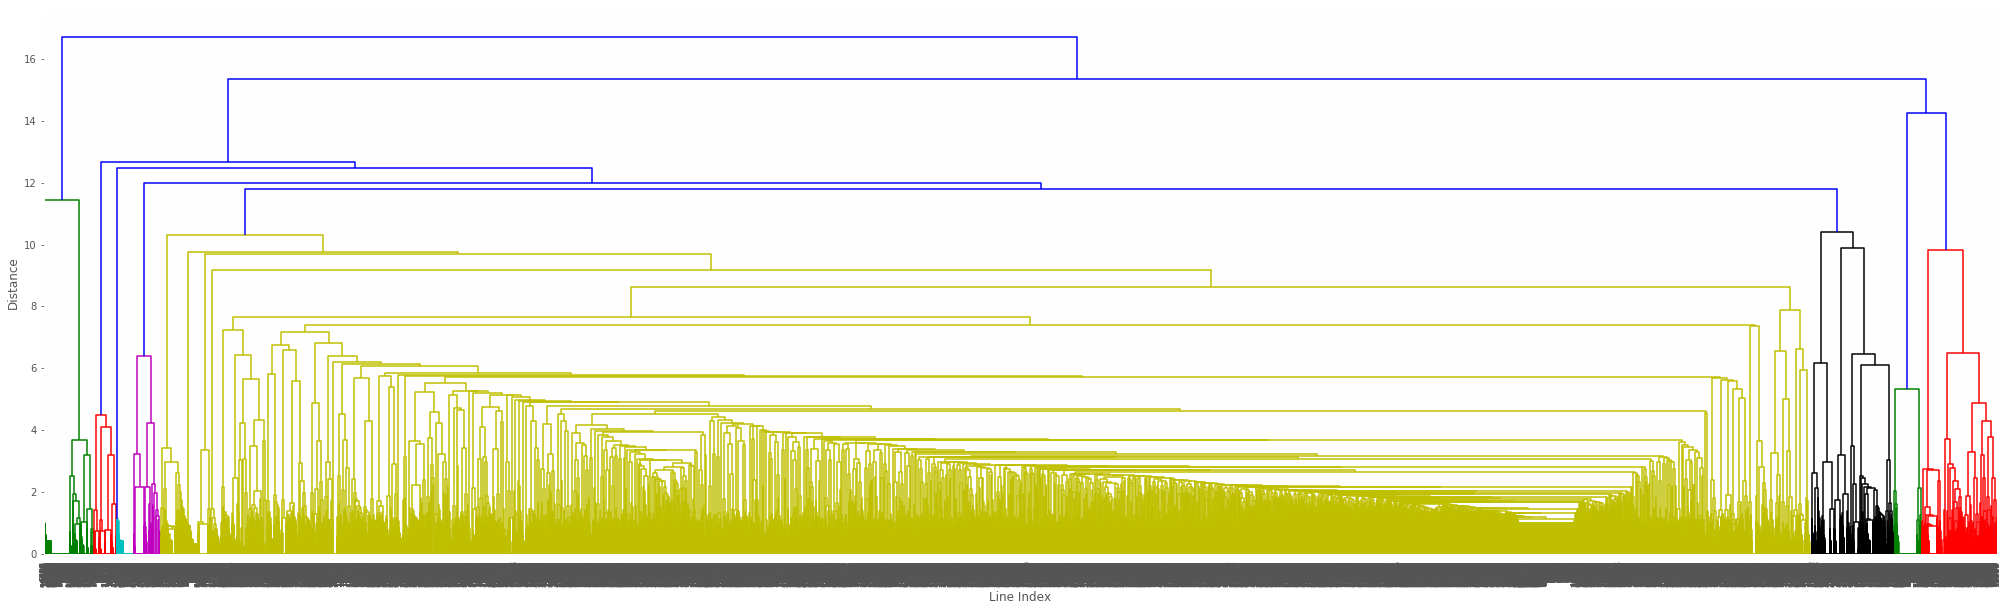

In [19]:
plt.figure(figsize=(35, 10))
plt.xlabel('Line Index')
plt.ylabel('Distance')
dendrogram(
    res,
    leaf_rotation=90.,  
    leaf_font_size=8.,  
)
plt.show()

In [20]:
videos_en_new['ward_euclidean_cluster'] = fcluster(res, 5, criterion='distance')
'done'

'done'

In [21]:
vid_ids = {}
for vid in applicable_vids:
    vid_ids[vid[0]] = True
    
count = 0
for index, row in videos_en_new.iterrows():
    if row.id in vid_ids:
        print row.sentence
        print row.ward_euclidean_cluster

Megan Fox recently visited and "critiqued" the Field Museum.
34
The common thread of questions were "How do you know" and "Do you have video evidence."
59
I explain why they don't have explicit explanations of the facts presented at the museum and why video evidence is shit when talking about dating things of the past.
59
My Social Media
52
Be Secular.
26
Absence of Clothing (use code "GE")
14
Do you know why Atheism Sucks?!?!?!?
27
Thank you all for making this possible.
56
In this funny moments vlog, I check out my 100k YouTube plaque (aka Play Button), which is part of the YouTube rewards system.
40
Feels great as a partner to finally get this in 2015.
40
And you can bet we've got a lot more coming... Let's get it.
40
Let's Celebrate... 100k YouTube Plaque.
40
Be sure to like, comment, and subscribe!
65
Sharing always helps.
40
● Follow me:
2
Twitter → https://twitter.com/PalaGilroySen
1
Twitch →  https://twitch.tv/Mantrousse
35
Instagram → http://instagram.com/palagilroysen
4
Faceb

Go to - https://mobilecoinkings.com/ for NBA Live Mobile and Madden Mobile coins!
32
ONLY $10 A MIL and delivery is always under 5 minutes.
40
Use my code NBG for an additional 15% off
14
Join CURSE!
40
The Best Network out there for youtubers over 1k Subs!!!
40
My Instagram - https://www.instagram.com/nerdbeamgaming_yt/
4
My Twitter - https://twitter.com/NerdBeamGaming
1
Thumbnails - Yonix,Juiced Up YT,Rha,ChaboyJoe,AjDahKing,MMPYT, and Mostly ME!
40
Graphics - AjDahKing
40
Background Music By NCS-https://www.youtube.com/user/NoCopyrightSounds
7
and Chuki Beats- https://www.youtube.com/user/CHUKImusic
40
100 ELITE PLAYER PACKS - https://www.youtube.com/watch?v=mv_6uskW3eE
40
50 MIL SHOPPING SPREE - https://www.youtube.com/watch?v=_ap3sDTwYqI&t=7s
40
BRO VS BRO - https://www.youtube.com/watch?v=nG6fw3klmU8
40
The Fam (Sub to them if your goat)
40
Jag-https://www.youtube.com/channel/UC_8Nl08RCdIRHgm7dmFrNOw
40
Champs - https://www.youtube.com/channel/UCLPyjVfGlAY7B9j-eomtCOg
40
RHA - ht

In [22]:
info = {}

for index, row in videos_en_new.iterrows():
    if row.ward_euclidean_cluster in [63]:
    #if row.ward_euclidean_cluster in [1409]: for second 100000
        if row.id not in info:
             info[row.id] = [row.channelTitle, []]
        info[row.id][1].append(row.sentence)

for vidId in info.keys():
    print str(info[vidId][0]) + "\t",
    for item in info[vidId][1]:
        print str(item) + " --- ",
    print

FskpZ gaming	Subscribe: http://www.youtube.com/subscription_center?add_user=FskpZ --- 
xTimelessGaming	

UnicodeEncodeError: 'ascii' codec can't encode character u'\xbb' in position 10: ordinal not in range(128)

In [ ]:
countVec1 = CountVectorizer(tokenizer=tokenize, binary=True).fit_transform(videos_en_new['sentence'])

In [ ]:
arr = countVec.get_feature_names()
for i in range(len(arr)):
    if arr[i] == "code":
        print i

In [ ]:
arr1 = countVec1.toarray()
indices = []
for i in range(len(arr1)):
    if arr1[i][3270] == 1:
        print i
        indices.append(i)
    

In [ ]:
index_distances = []
for index, row in videos_en_new.iterrows():
    if row.ward_euclidean_cluster in [63]:
        index_distances.append(arr1[index])

average = []
for i in range(len(index_distances[0])):
    average.append(0)
    for array in index_distances:
        average[i] += array[i]
    average[i] /= (len(index_distances) *1.0)
        
    


In [ ]:
def get_array_from_sentence(sentence):
    ret_val = [0] * len(arr1[0])
    
    split = re.split('\W+', sentence)
    for word in split:
        if word in arr:
            ret_val[arr.index(word)] = 1
    return ret_val  

def get_total_distance(sentence):
    array = list(index_distances)
    array.append(get_array_from_sentence(sentence))
    return cosine_distances(array)

def get_distance_to_average(sentence):
    distance = cosine_distances([average, get_array_from_sentence(sentence)])[0][1]
    print distance


get_distance_to_average("use my code to get to the thing and go to the baseline blah blah hahaha pop")
get_distance_to_average("hello world")
get_distance_to_average("I like turtles and would like to go to the store")



In [ ]:
twod = get_total_distance("use my code in the chat")
squareform(twod, checks = False)



In [ ]:
twod = get_total_distance("I like turtles and potatoes")
squareform(twod, checks = False)
